## Strategy backtesting notebook
The following notebook is used to backtest the strategy and generate results to be analyzed later. 

### Env variables and imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import datetime
import os.path
import sys
import uuid
import copy
import json

# import warnings

import pandas as pd
import requests
import tqdm
import backtrader as bt
import pyfolio as pf
from matplotlib import warnings

warnings.filterwarnings("ignore")  # Avoid some noise

/home/narboom23/Projects/licenta/env/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Local location configs
PROJECT_LOCATION = "/home/narboom23/Projects/licenta"
MOUNT_LOCATION = f"{PROJECT_LOCATION}/mount/"
DATA_LOCATION = f"{MOUNT_LOCATION}"
TICKERS_LOCATION = f"{DATA_LOCATION}/tickers"

### Utilities

In [3]:
def get_ticker_csv_path(ticker_name):
    return f"{TICKERS_LOCATION}/{ticker_name}.csv"


def get_ticker_csv_as_df(ticker_name):
    return pd.read_csv(get_ticker_csv_path(ticker_name))

### Strategy
The main strategy class used

In [4]:
class RaynerTeoStrategy(bt.Strategy):
    """
    Rayner Teo Strategy with some additional logging

    Market:
      any stock

    Define the trend:
      (closing?) price above the 200-day moving average

    Entry:
      10-period RSI below 30 (buy on the next day's open)

    Exit:
      10-period RSI above 40, or after 10 trading days (sell on the next day's open)
    """

    params = (
        # SMA
        ("maperiod", 15),
        # RSI
        ("rsi_open_period", 10),
        ("rsi_close_period", 30),
        # Other
        ("days_ago_close_period", 10),
        ("printlog", False),
    )

    def log(self, txt, dt=None, doprint=False):
        """Logging function for this strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()

            self.inds[d]["sma"] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.maperiod
            )
            self.inds[d]["rsi"] = bt.indicators.RSI(
                d.close, period=self.params.rsi_open_period, safediv=True
            )
            #             self.inds[d]["sto512"] = bt.indicators.Stochastic(
            #                 d, period=512, safediv=True
            #             )

            self.inds[d]["order_placed_days_ago"] = 0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log(
                    "SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size

            if not pos:  # no market / no orders
                if d.close[0] > self.inds[d]["sma"][0] and self.inds[d]["rsi"][0] < 30:
                    self.buy(data=d)
            else:
                if (
                    self.inds[d]["rsi"][0] >= self.params.rsi_close_period
                    or self.inds[d]["order_placed_days_ago"]
                    == self.params.days_ago_close_period
                    and self.inds[d]["sto512"][0] >= 84
                ):
                    #                 if self.inds[d]['rsi'][0] > self.params.rsi_close_period or self.inds[d]['order_placed_days_ago'] == self.params.days_ago_close_period:
                    self.sell(data=d)
                    self.inds[d]["order_placed_days_ago"] = 0
                else:
                    self.inds[d]["order_placed_days_ago"] += 1

    def stop(self):
        self.log(
            f"(MA Period {self.params.maperiod}, "
            f"RSI open {self.params.rsi_open_period}, "
            f"RSI close {self.params.rsi_close_period}, "
            f"Close after {self.params.days_ago_close_period} days) "
            f"Ending Value {self.broker.getvalue()}",
            doprint=False,
        )

## Run configuration

In [14]:
DEFAULT_FROM_DATE = datetime.datetime(2004, 1, 1)
DEFAULT_TO_DATE = datetime.datetime(2020, 12, 31)
DEFAULT_CASH = 100.0
DEFAULT_COMMISION = 0.0
DEFAULT_CPU_COUNT = 4

MY_OPTIMIZED_KWARGS = {
    "maperiod": range(200, 221, 10),
    "rsi_open_period": 6,
    "rsi_close_period": 50,
    "days_ago_close_period": 50,  #  50 is the best I've found! but data currently says 20
}
STRATEGY_OUT_OF_THE_BOX_KWARGS = {
    "maperiod": 200,
    "rsi_open_period": 10,
    "rsi_close_period": 40,
    "days_ago_close_period": 10,
}
DEFAULT_KWARGS = MY_OPTIMIZED_KWARGS

DEFAULT_TICKER_LIST = [
    "A",
    "AAL",
    "AAP",
    "AAPL",
    "ABBV",
    "ABC",
    "ABMD",
    "ABT",
    "ACN",
    "ADBE",
    "ADI",
    "ADM",
    "ADP",
    "ADSK",
    "AEE",
    "AEP",
    "AES",
    "AFL",
    "AIG",
    "AIZ",
    "AJG",
    "AKAM",
    "ALB",
    "ALGN",
    "ALK",
    "ALL",
    "ALLE",
    "ALXN",
    "AMAT",
    "AMD",
    "AME",
    "AMGN",
    "AMP",
    "AMT",
    "AMZN",
    "ANSS",
    "ANTM",
    "AON",
    "AOS",
    "APA",
    "APD",
    "APH",
    "APTV",
    "ARE",
    "ATO",
    "ATVI",
    "AVB",
    "AVGO",
    "AVY",
    "AWK",
    "AXP",
    "AZO",
]
DEFAULT_TICKER_LIST = [
    "A",
    "AAPL",
    "ABC",
    "ABMD",
    "ABT",
    "ADBE",
    "ADI",
    "ADM",
    "ADP",
    "ADSK",
    "AEE",
    "AEP",
    "AES",
    "AFL",
    "AIG",
    "AJG",
    "AKAM",
    "ALB",
    "ALGN",
    "ALK",
    "ALL",
    "ALXN",
    "AMAT",
    "AMD",
    "AME",
    "AMGN",
    "AMT",
    "AMZN",
    "ANSS",
    "AON",
    "AOS",
    "APA",
    "APD",
    "APH",
    "ARE",
    "ATO",
    "ATVI",
    "AVB",
    "AVY",
    "AXP",
    "AZO",
]
# DEFAULT_TICKER_LIST = [
#     '^GSPC',
#     '^DJI',
#     '^IXIC',
#     '^NYA',
#     '^XAX',
#     '^BUK100P',
#     '^FTSE',
#     '^GDAXI',
#     '^FCHI',
#     '^STOXX50E', '^N100',
#     '^BFX', '^STI',
#     '^AXJO',
#     '^AORD',
#     '^JKSE',
#     '^NZ50',
#     '^GSPTSE',
# ]

In [19]:
# Create a cerebro entity
cerebro = bt.Cerebro(stdstats=False)

cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)


# Add a strategy
# strats = cerebro.addstrategy(RaynerTeoStrategy, **DEFAULT_KWARGS)
strats = cerebro.optstrategy(RaynerTeoStrategy, **DEFAULT_KWARGS)

datalist = [
    (get_ticker_csv_path(ticker_name), ticker_name)
    for ticker_name in DEFAULT_TICKER_LIST
]

for i in range(len(DEFAULT_TICKER_LIST)):
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datalist[i][0],
        name=datalist[i][1],
        # Do not pass values before this date
        fromdate=DEFAULT_FROM_DATE,
        # Do not pass values before this date
        todate=DEFAULT_TO_DATE,
        # Do not pass values after this date
        reverse=False,
    )
    data.plotinfo.plot = False

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(DEFAULT_CASH)

# Add pyfolio analyzer for stats
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.PercentSizer, percents=33)

# Set the commission
cerebro.broker.setcommission(commission=DEFAULT_COMMISION)

# Run over everything
strat = cerebro.run(maxcpus=DEFAULT_CPU_COUNT)

# Print out the final result
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

Final Portfolio Value: 100.00


In [29]:
pyfoliozer = strat[1][0].analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [24]:
strat[0][0]

In [32]:
dir(strat[0][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'analyzers',
 'p',
 'params',
 'strategycls']

In [34]:
dir(strat[0][0].params)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_derive',
 '_get',
 '_getdefaults',
 '_getitems',
 '_getkeys',
 '_getkwargs',
 '_getkwargsdefault',
 '_getpairs',
 '_getpairsbase',
 '_getrecurse',
 '_gettuple',
 '_getvalues',
 'days_ago_close_period',
 'isdefault',
 'maperiod',
 'notdefault',
 'printlog',
 'rsi_close_period',
 'rsi_open_period']

In [36]:
strat[0][0].params.maperiod

200

In [37]:
strat[1][0].params.maperiod

210

Start date,2004-01-02
End date,2020-12-30
Total months,203
,Backtest
Annual return,12.6%
Cumulative returns,654.2%
Annual volatility,15.2%
Sharpe ratio,0.86
Calmar ratio,0.58
Stability,0.95
Max drawdown,-22.0%


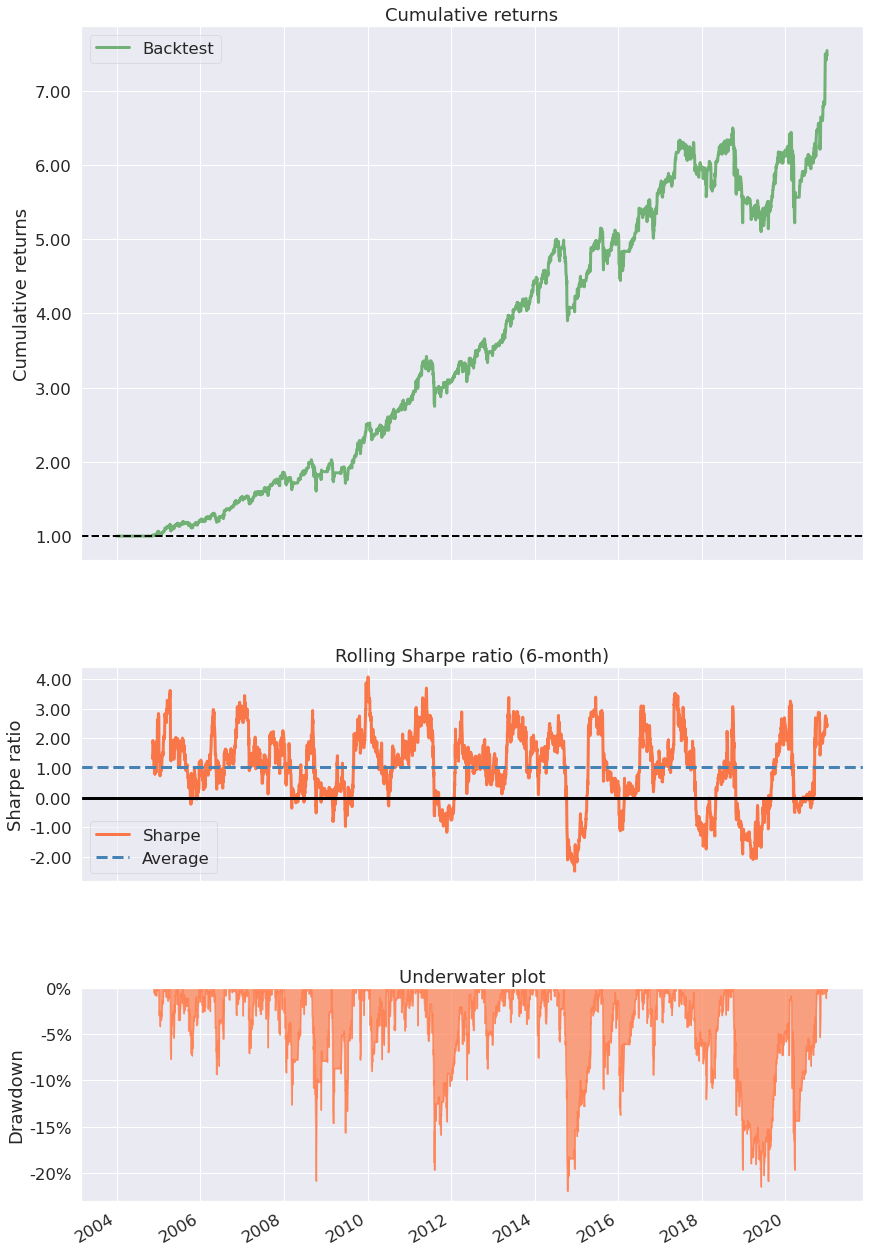

In [30]:
pf.create_simple_tear_sheet(returns)

Start date,2004-01-02
End date,2020-12-30
Total months,203
,Backtest
Annual return,15.1%
Cumulative returns,983.6%
Annual volatility,24.5%
Sharpe ratio,0.70
Calmar ratio,0.36
Stability,0.92
Max drawdown,-42.2%


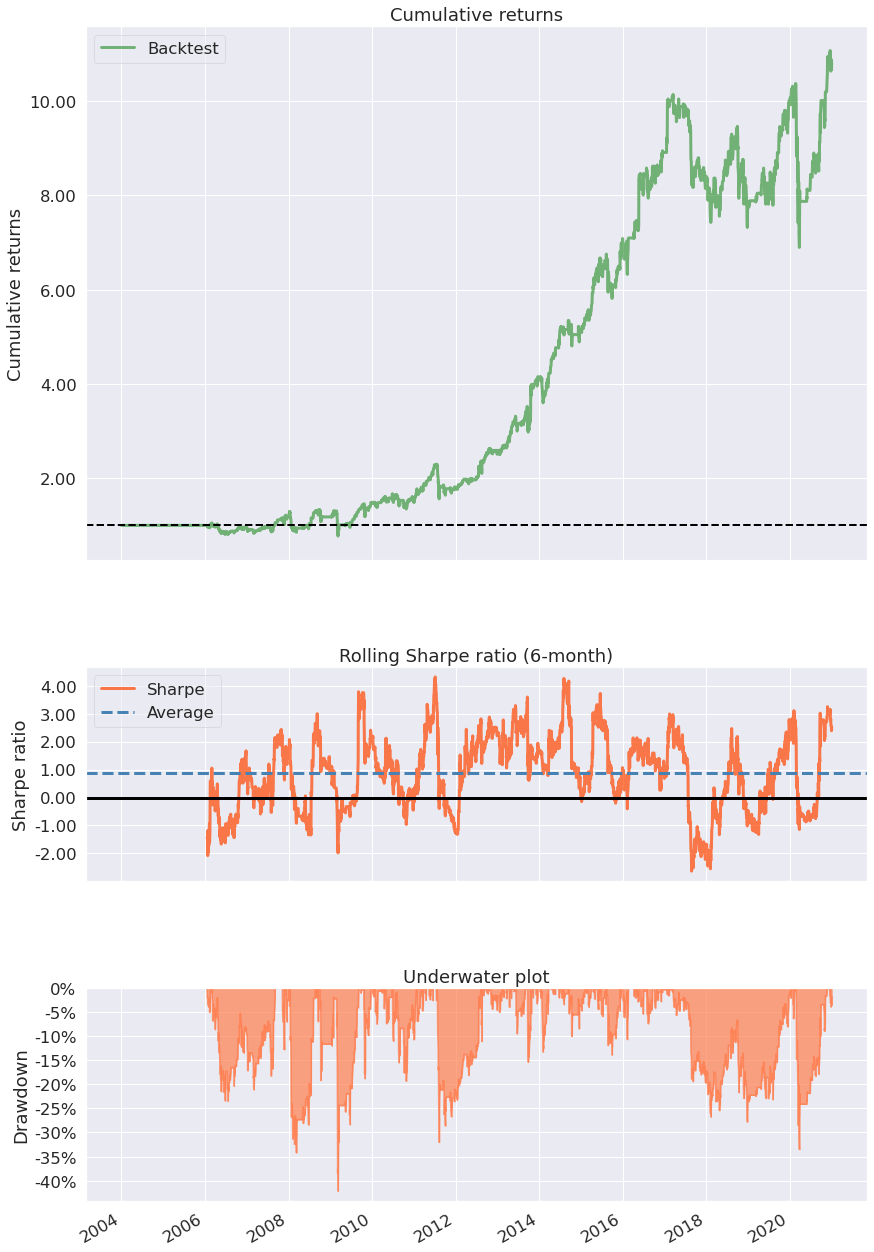

In [157]:
pf.create_simple_tear_sheet(returns)

Start date,2004-01-02
End date,2020-12-30
Total months,203
,Backtest
Annual return,5.4%
Cumulative returns,145.8%
Annual volatility,18.6%
Sharpe ratio,0.38
Calmar ratio,0.10
Stability,0.76
Max drawdown,-52.5%


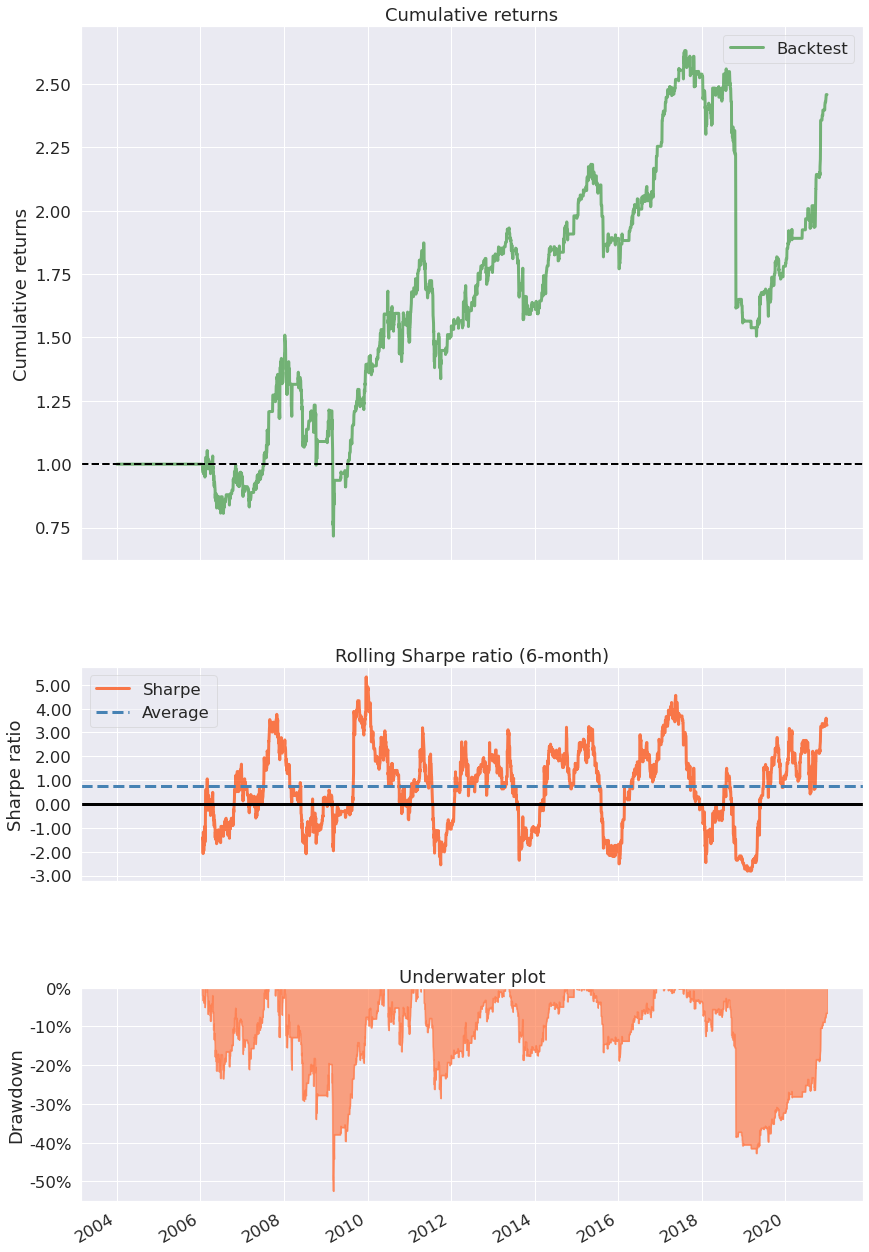

In [131]:
pf.create_simple_tear_sheet(returns)

In [111]:
for fl, t in datalist:
    with open(fl, "r") as f:
        if len(f.readlines()) < 5000:
            print(t)

In [112]:
366 * 14

5124